In [26]:
import torch
import numpy as np
import random
import time
from torch.utils.data import Dataset


class ModelTemplate():
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)

        self.stats = {'losses': [],
                      'val_losses': [],
                      'train_time': [],
                      'val_time': [],
                      'n_epochs': 0}

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

    def save(self, filename='model.pth'):
        model_state = {
            'model': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'stats': self.stats
        }
        torch.save(model_state, filename)

    def load(self, filename='model.pth'):
        model_state = torch.load(filename, weights_only=False)
        self.model.load_state_dict(model_state['model'])
        self.optimizer.load_state_dict(model_state['optimizer'])
        self.stats = model_state['stats']

        self.model.train()

    def log_update(self, train_time, loss, val_time, val_loss, train_loader, val_loader):
        self.stats['train_time'].append(train_time)
        self.stats['losses'].append(loss)
        self.stats['val_time'].append(val_time)
        self.stats['val_losses'].append(val_loss)
        self.stats['n_epochs'] += 1

    def log_output(self, verbose=1, formatstr=''):
        s = [f'epoch {self.stats['n_epochs']}',
             f'train_time: {{{formatstr}}}'.format(self.stats['train_time'][-1]),
             f'loss: {{{formatstr}}}'.format(self.stats['losses'][-1])]
        if self.stats['val_losses'][-1] is not None:
            s.append(f'val_time: {{{formatstr}}}'.format(self.stats['val_time'][-1]))
            s.append(f'val_loss: {{{formatstr}}}'.format(self.stats['val_losses'][-1]))
        if verbose == 1:
            print(' '.join(s))
        return s
    
    class metrics():
        def __init__(self):
            self.acc = []
        
        def update(self, yhat, y):
            self.acc.append((yhat==y).sum().item())


    def _train_one_epoch(self, dataloader):
        self.model.train()

        losses = []
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            yhat = self.model(X_batch)
            loss = self.loss_fn(yhat, y_batch)
            
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

            losses.append(loss.item())
        return np.mean(losses)

    def _eval_one_epoch(self, dataloader):
        self.model.eval()
        losses = []
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            yhat = self.model(X_batch)
            loss = self.loss_fn(yhat, y_batch)
            losses.append(loss.item())
        return np.mean(losses)

    def train(self, train_loader, val_loader=None, epoch_num=10, verbose=0, SEED=42):
        self.set_seed(SEED)
        for _ in range(epoch_num):
            start_time = time.time()
            loss = self._train_one_epoch(train_loader)
            end_time = time.time()
            train_time = end_time - start_time

            val_loss = None
            val_time = None
            if val_loader is not None:
                start_time = time.time()
                val_loss = self._eval_one_epoch(val_loader)
                end_time = time.time()
                val_time = end_time - start_time

            self.log_update(train_time, loss, val_time, val_loss, train_loader, val_loader)
            self.log_output(verbose=verbose)

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.as_tensor(X, dtype=float)
        y_tensor = self.model(X_tensor.to(self.device))
        self.model.train()
        y = y_tensor.detach().cpu().numpy()

        return y


class __MyModel__(ModelTemplate):
    def __init__(self, model, loss_fn, optimizer):
        super().__init__(model, loss_fn, optimizer)
        self.stats['p'] = []

    def log_update(self, train_time, loss, val_time, val_loss):
        super().log_update(train_time, loss, val_time, val_loss)
        p = self.model.state_dict()
        self.stats['p'].append([p['linear.bias'].item(), p['linear.weight'].item()])

    def log_output(self, verbose=0):
        s = super().log_output(verbose=0, formatstr=':.6f')
        s.append(f'p: [{self.stats['p'][-1][0]:.6f}, {self.stats['p'][-1][1]:.6f}]')
        if verbose == 1:
            print(' '.join(s))
        return s


class __MyData__(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=float).reshape(-1, 1)
        self.y = torch.tensor(y, dtype=float).reshape(-1, 1)

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.y)

In [79]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/horse-colic/horse-colic.data'
# df = pd.read_csv(url, sep='\\s+', header=None)
# df = df.replace("?", np.NaN)

# df.fillna(0, inplace=True)
# df = df.drop(columns=[2, 24, 25, 26, 27])
# df[23] = df[23].replace({1: 1, 2: 0})
# X = df.iloc[:, :-1].to_numpy().astype(float)
# y = df[23].to_numpy().astype(int)


from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.3, random_state=0)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)


from sklearn.preprocessing import StandardScaler
mms = StandardScaler()
X_train = mms.fit_transform(X_train, y_train)
X_test = mms.transform(X_test)

import torch
from torch.utils.data import Dataset, DataLoader

class MyData(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=float)
        self.y = torch.tensor(y, dtype=float).reshape(-1, 1)

    def __getitem__(self, index):
        return (self.X[index], self.y[index])

    def __len__(self):
        return len(self.y)


train_set = MyData(X_train, y_train)
val_set = MyData(X_test, y_test)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16)

In [81]:
X_train

array([[-0.59635346, -0.51713419],
       [ 0.3937561 , -1.35813138],
       [ 1.33167696, -1.16636502],
       [-1.52208256, -0.33314461],
       [-1.20280449,  0.64649722],
       [-0.65443973,  0.48658224],
       [ 1.00612744, -1.81018492],
       [-0.28996374, -1.5477782 ],
       [ 0.03349394, -0.65113935],
       [-0.94744907,  0.76650095],
       [ 0.61340448, -1.50292036],
       [ 1.90666775, -0.49298432],
       [-1.51519782, -0.37657626],
       [ 0.83679088,  1.55233811],
       [-0.5673415 ,  0.20360244],
       [ 1.34884731, -0.7930775 ],
       [-0.19406929,  0.92544509],
       [-1.57387163, -1.21907634],
       [-0.72861616,  1.22434395],
       [ 1.36732327,  0.53003428],
       [-1.16333041,  1.31264925],
       [-0.49927845,  1.19894001],
       [ 1.24056139, -1.50978838],
       [-0.31599591, -0.18511142],
       [-0.00410317, -0.69877045],
       [-0.39572336,  1.22179345],
       [-1.59788135,  1.05926647],
       [-0.95127788,  1.20886702],
       [ 0.2648369 ,

In [84]:
X_train[0].size


2

In [86]:
from torch.utils.data import TensorDataset

xxx = TensorDataset(torch.as_tensor(X_train))
yyy = TensorDataset(torch.as_tensor(y_train))

In [88]:
xxx[0]

(tensor([-0.5964, -0.5171], dtype=torch.float64),)

In [76]:
import torch.nn as nn
from torch.nn.modules import Linear

class LoR(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = Linear(in_features=2, out_features=1, dtype=float)
        self.activation = nn.Sigmoid()

    def forward(self, X):
        # pred = self.activation(self.linear(X))
        pred = self.linear(X)
        # return (pred >= 0).float()
        return pred

In [23]:
len(train_loader.dataset)


80

In [77]:
class LoRModel(ModelTemplate):
    def __init__(self, model, loss_fn, optimizer):
        super().__init__(model, loss_fn, optimizer)
        self.stats['acc_train'] = []
        self.stats['acc_val'] = []

    def compute_acc(self, dataloader):
        with torch.no_grad():
            acc = []
            for X_batch, y_batch in dataloader:
                yhat = torch.sigmoid(self.model(X_batch))
                y_pred = (yhat>=0.5).to(float)
                acc.append((y_pred==y_batch).sum().item())
            # print(acc_train)
        return np.sum(acc)/len(dataloader.dataset)

    def log_update(self, train_time, loss, val_time, val_loss, train_loader, val_loader):
        super().log_update(train_time, loss, val_time, val_loss, train_loader, val_loader)
        acc_train = self.compute_acc(train_loader)
        acc_val = self.compute_acc(val_loader)
        self.stats['acc_train'].append(acc_train)
        self.stats['acc_val'].append(acc_val)


        # p = self.model.state_dict()
        # self.stats['acc'].append([p['linear.bias'].item(), p['linear.weight'].item()])

    def log_output(self, verbose=0):
        s = super().log_output(verbose=0, formatstr=':.6f')
        s.append(f'acc_train: {self.stats['acc_train'][-1]:.6f}')
        s.append(f'acc_val: {self.stats['acc_val'][-1]:.6f}')
        # s.append(f'p: [{self.stats['p'][-1][0]:.6f}, {self.stats['p'][-1][1]:.6f}]')
        if verbose == 1:
            print(' '.join(s))
        return s

In [69]:
ttt = train_loader.dataset[0][0]

(ttt<-0.55).to(float)

tensor([1., 0.], dtype=torch.float64)

In [78]:
from torch.optim import SGD
from torch.nn import BCEWithLogitsLoss, BCELoss

original_model = LoR()
model = LoRModel(model=original_model, loss_fn=BCEWithLogitsLoss(),
                 optimizer=SGD(original_model.parameters(), lr = 0.1))

model.train(train_loader, val_loader, epoch_num=100, verbose=1)

epoch 1 train_time: 0.002500 loss: 0.583988 val_time: 0.001504 val_loss: 0.528253 acc_train: 0.687500 acc_val: 0.750000
epoch 2 train_time: 0.003004 loss: 0.544656 val_time: 0.001507 val_loss: 0.490200 acc_train: 0.725000 acc_val: 0.750000
epoch 3 train_time: 0.003499 loss: 0.513808 val_time: 0.001000 val_loss: 0.459465 acc_train: 0.762500 acc_val: 0.750000
epoch 4 train_time: 0.004028 loss: 0.490238 val_time: 0.000000 val_loss: 0.434522 acc_train: 0.762500 acc_val: 0.750000
epoch 5 train_time: 0.002996 loss: 0.470588 val_time: 0.001306 val_loss: 0.413784 acc_train: 0.787500 acc_val: 0.850000
epoch 6 train_time: 0.002999 loss: 0.455354 val_time: 0.000000 val_loss: 0.396341 acc_train: 0.787500 acc_val: 0.850000
epoch 7 train_time: 0.003015 loss: 0.442161 val_time: 0.000506 val_loss: 0.381378 acc_train: 0.787500 acc_val: 0.850000
epoch 8 train_time: 0.004508 loss: 0.431538 val_time: 0.001000 val_loss: 0.368658 acc_train: 0.800000 acc_val: 0.850000
epoch 9 train_time: 0.003007 loss: 0.423

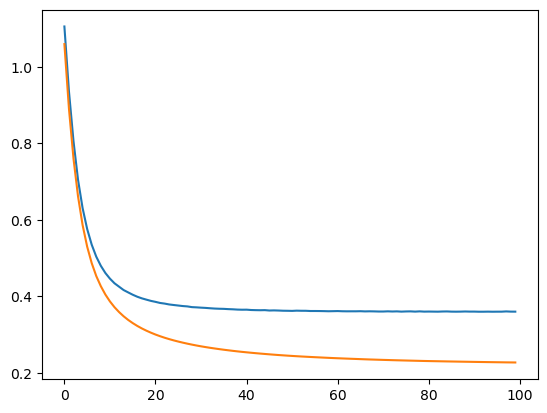

In [40]:
import matplotlib.pyplot as plt

plt.plot(model.stats['losses'])
plt.plot(model.stats['val_losses'])